In [1]:
import anndata
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.callbacks import EarlyStopping
import seaborn as sb

adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-15 14:05:43.700127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `a

In [2]:
# generate numerical values for each batch category
from sklearn.preprocessing import LabelEncoder
# set up categories variable
categories = adata.obs['batch']
# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Fit and transform the categories to integers
numerical_categories = label_encoder.fit_transform(categories)
numerical_categories.shape

(450,)

In [3]:
#normalizaiton
gene_expression_data = adata.layers['logcounts']
from sklearn.preprocessing import MinMaxScaler
# Min-max normalization
scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)
number_samples = adata.shape[0]
number_genes = adata.shape[1]
input_dim = number_genes

In [4]:
input_shape = (12165,)  # Set to match your actual data
encoding_dim = 64  # Output dimension

In [5]:
from keras import layers, models

# Define the input shape
input_shape = (12165,)  # Number of genes

# Define the encoder function
def build_encoder():
    model = models.Sequential()
    model.add(layers.Input(shape=(12165,)))  # Set to match the input shape of 12165
    model.add(layers.Dense(256, activation='linear'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='linear'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='linear'))  # Encoded representation
    return model

# Define the decoder function (adjusted as discussed)
def build_decoder():    
    model = models.Sequential()
    model.add(layers.Input(shape=(64,)))  # Input shape should match the output of the encoder
    model.add(layers.Dense(128, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(12165, activation='sigmoid'))  # Output layer should match the input shape of the original data
    return model

In [6]:
# Define the domain classifier function
def build_domain_classifier(input_shape, num_domains):
    model = models.Sequential()    
    model.add(layers.Input(shape=input_shape))    
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU()) 
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(64, activation=None))
    model.add(layers.LeakyReLU()) 
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(32, activation=None))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())    
    model.add(layers.Dense(num_domains, activation='softmax'))  # num_domains is the number of classes
    return model

In [7]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_value=1.0, **kwargs):
        self.lambda_value = lambda_value
        super(GradientReversalLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Define custom gradient behavior
        @tf.custom_gradient
        def reverse_gradients(x):
            # Forward pass: output is just the input
            def grad(dy):
                # Gradient computation: reversed and scaled by lambda_value
                return -self.lambda_value * dy
            return x, grad
        
        return reverse_gradients(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_value": self.lambda_value})
        return config

In [8]:
# Define the encoder, decoder, and discriminator (assuming these functions are defined as in previous examples)
encoder = build_encoder()  # Assuming build_encoder() is defined
decoder = build_decoder()  # Assuming build_decoder() is defined
discriminator = build_domain_classifier((64,), 9)  # Assuming build_domain_classifier() is defined

# Optimizers for each model
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Assuming you have 1000 training samples as an example
num_samples = adata.shape[0]  # Replace this with your actual number of samples
batch_size = 64

# Training loop
num_epochs = 200

# Calculate the number of steps per epoch
num_steps_per_epoch = num_samples // batch_size

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create a combined model for the encoder and decoder if training together
combined_model = models.Sequential([encoder, decoder])

# Compile combined model
combined_model.compile(optimizer='adam', loss='mean_squared_error')  # Use an appropriate loss for your case

In [9]:
num_domains = len(np.unique(categories))
X_data = gene_expression_data
y_domains = numerical_categories
grl = GradientReversalLayer(lambda_value=10.0)  # Instantiate GRL

reconstruction_losses = []  # To store averaged reconstruction loss values per epoch
domain_losses = []          # To store averaged domain loss values per epoch

# Training loop
for epoch in range(num_epochs):
    # Initialize accumulators for the epoch
    total_reconstruction_loss = 0.0
    total_domain_loss = 0.0
    num_batches = 0  # To count batches in the current epoch

    for step in range(num_steps_per_epoch):
        # Get a batch of data
        batch_indices = []
        for domain in range(num_domains):
            domain_indices = np.where(y_domains == domain)[0]
            domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=True)
            batch_indices.append(domain_batch_indices)

        X_batch = X_data[np.concatenate(batch_indices)]
        y_true_batch = y_domains[np.concatenate(batch_indices)]
        y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=9)  # Convert labels to categorical

        # Train on reconstruction loss
        with tf.GradientTape(persistent=True) as tape:
            # Encode
            encoded_output = encoder(X_batch, training=True)
            
            # Decode
            decoded_output = decoder(encoded_output, training=True)

            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))

        # Calculate gradients for encoder and decoder using the same tape
        encoder_gradients = tape.gradient(reconstruction_loss, encoder.trainable_variables)
        # Since you cannot use the same tape again, we will need to create a new one
        decoder_gradients = tape.gradient(reconstruction_loss, decoder.trainable_variables)

        # Apply gradients for encoder and decoder
        encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
        decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))

        # Accumulate the reconstruction loss
        total_reconstruction_loss += reconstruction_loss.numpy()

        # Now, train on domain loss
        with tf.GradientTape() as tape:
            # Apply gradient reversal
            encoded_output_grl = grl(encoded_output)

            # Domain output (using the output from GRL)
            domain_output = discriminator(encoded_output_grl, training=True)

            # Calculate domain loss
            domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)
            domain_loss = tf.reduce_mean(domain_loss)  # Average over the batch

        # Calculate gradients for the discriminator
        discriminator_gradients = tape.gradient(domain_loss, discriminator.trainable_variables)

        # Apply gradients to the discriminator
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        # Accumulate the domain loss
        total_domain_loss += domain_loss.numpy()

        # Increment the batch count
        num_batches += 1

    # Calculate average losses for the epoch
    average_reconstruction_loss = total_reconstruction_loss / num_batches
    average_domain_loss = total_domain_loss / num_batches

    # Store the average losses
    reconstruction_losses.append(average_reconstruction_loss)
    domain_losses.append(average_domain_loss)

    # Print out scalar loss values for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Reconstruction Loss: {average_reconstruction_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Domain Loss: {average_domain_loss}")


Epoch 1/200, Average Reconstruction Loss: 0.0696281987641539
Epoch 1/200, Average Domain Loss: 2.71375914982387
Epoch 2/200, Average Reconstruction Loss: 0.01881905073033912
Epoch 2/200, Average Domain Loss: 1.8159596238817488
Epoch 3/200, Average Reconstruction Loss: 0.009734879780028547
Epoch 3/200, Average Domain Loss: 1.5718634980065482
Epoch 4/200, Average Reconstruction Loss: 0.007855633406766824
Epoch 4/200, Average Domain Loss: 1.5886003971099854
Epoch 5/200, Average Reconstruction Loss: 0.007231963399265494
Epoch 5/200, Average Domain Loss: 1.4913158416748047
Epoch 6/200, Average Reconstruction Loss: 0.006769503466784954
Epoch 6/200, Average Domain Loss: 1.4708644662584578
Epoch 7/200, Average Reconstruction Loss: 0.006602599152496883
Epoch 7/200, Average Domain Loss: 1.483471393585205
Epoch 8/200, Average Reconstruction Loss: 0.00653176661580801
Epoch 8/200, Average Domain Loss: 1.3873907327651978
Epoch 9/200, Average Reconstruction Loss: 0.006324762744562966
Epoch 9/200, Ave

In [15]:
for epoch in range(num_epochs):
    total_reconstruction_loss = 0.0
    total_domain_loss = 0.0
    num_batches = 0

    for step in range(num_steps_per_epoch):
        # Get a batch of data (same as before)
        # ...

        # Train on reconstruction loss
        with tf.GradientTape(persistent=True) as tape:
            # Encode
            encoded_output = encoder(X_batch, training=True)

            # Decode
            decoded_output = decoder(encoded_output, training=True)

            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))

        # Calculate gradients for encoder and decoder using the same tape
        encoder_gradients_reconstruction = tape.gradient(reconstruction_loss, encoder.trainable_variables)
        decoder_gradients = tape.gradient(reconstruction_loss, decoder.trainable_variables)

        # Now, train on domain loss using a new tape
        with tf.GradientTape() as tape:
            # Apply gradient reversal
            encoded_output_grl = grl(encoded_output)

            # Domain output
            domain_output = discriminator(encoded_output_grl, training=True)

            # Calculate domain loss
            domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)
            domain_loss = tf.reduce_mean(domain_loss)  # Average over the batch

        # Calculate gradients for the discriminator
        discriminator_gradients = tape.gradient(domain_loss, discriminator.trainable_variables)

        # Update discriminator
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        # Now accumulate the gradients for the encoder based on domain loss
        encoder_gradients_domain = tape.gradient(domain_loss, encoder.trainable_variables)

        # Combine the gradients (for simplicity, you can weight them)
        combined_encoder_gradients = [
            encoder_gradients_reconstruction[i] + encoder_gradients_domain[i]
            for i in range(len(encoder_gradients_reconstruction))
        ]

        # Apply combined gradients to the encoder
        encoder_optimizer.apply_gradients(zip(combined_encoder_gradients, encoder.trainable_variables))

        # Apply gradients to the decoder
        decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))

        # Accumulate losses
        total_reconstruction_loss += reconstruction_loss.numpy()
        total_domain_loss += domain_loss.numpy()
        num_batches += 1

    # Calculate average losses for the epoch (same as before)
    average_reconstruction_loss = total_reconstruction_loss / num_batches
    average_domain_loss = total_domain_loss / num_batches

    # Store and print average losses
    reconstruction_losses.append(average_reconstruction_loss)
    domain_losses.append(average_domain_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Average Reconstruction Loss: {average_reconstruction_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Domain Loss: {average_domain_loss}")


RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

In [19]:
num_domains = len(np.unique(categories))
X_data = gene_expression_data
y_domains = numerical_categories
grl = GradientReversalLayer(lambda_value=10.0)  # Instantiate GRL

reconstruction_losses = []  # To store averaged reconstruction loss values per epoch
domain_losses = []          # To store averaged domain loss values per epoch

# Training loop
for epoch in range(num_epochs):
    # Initialize accumulators for the epoch
    total_reconstruction_loss = 0.0
    total_domain_loss = 0.0
    num_batches = 0  # To count batches in the current epoch

    for step in range(num_steps_per_epoch):
        # Get a batch of data
        batch_indices = []
        for domain in range(num_domains):
            domain_indices = np.where(y_domains == domain)[0]
            domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=True)
            batch_indices.append(domain_batch_indices)

        X_batch = X_data[np.concatenate(batch_indices)]
        y_true_batch = y_domains[np.concatenate(batch_indices)]
        y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=9)  # Convert labels to categorical

        # Train on reconstruction loss
        with tf.GradientTape(persistent=True) as tape_reconstruction:
            # Encode
            encoded_output = encoder(X_batch, training=True)
            
            # Decode
            decoded_output = decoder(encoded_output, training=True)

            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))

        # Calculate gradients for encoder and decoder using the reconstruction tape
        encoder_gradients_reconstruction = tape_reconstruction.gradient(reconstruction_loss, encoder.trainable_variables)
        
        # Apply gradients for encoder and decoder
        encoder_optimizer.apply_gradients(zip(encoder_gradients_reconstruction, encoder.trainable_variables))
        decoder_optimizer.apply_gradients(zip(tape_reconstruction.gradient(reconstruction_loss, decoder.trainable_variables), decoder.trainable_variables))

        # Accumulate the reconstruction loss
        total_reconstruction_loss += reconstruction_loss.numpy()

        # Now, train on domain loss using a new tape
        with tf.GradientTape(persistent=True) as tape_domain:
            # Apply gradient reversal
            encoded_output_grl = grl(encoded_output)

            # Domain output
            domain_output = discriminator(encoded_output_grl, training=True)

            # Calculate domain loss
            domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)
            domain_loss = tf.reduce_mean(domain_loss)  # Average over the batch

        # Calculate gradients for the discriminator
        discriminator_gradients = tape_domain.gradient(domain_loss, discriminator.trainable_variables)

        # Apply gradients to the discriminator
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        # Now accumulate the gradients for the encoder based on domain loss
        encoder_gradients_domain = tape_domain.gradient(domain_loss, encoder.trainable_variables)

        # Combine the encoder gradients (if needed)
        combined_encoder_gradients = [
            encoder_gradients_reconstruction[i] + encoder_gradients_domain[i]
            for i in range(len(encoder_gradients_reconstruction))
        ]

        # Apply combined gradients to the encoder
        encoder_optimizer.apply_gradients(zip(combined_encoder_gradients, encoder.trainable_variables))

        # Accumulate the domain loss
        total_domain_loss += domain_loss.numpy()

        # Increment the batch count
        num_batches += 1

    # Calculate average losses for the epoch
    average_reconstruction_loss = total_reconstruction_loss / num_batches
    average_domain_loss = total_domain_loss / num_batches

    # Store the average losses
    reconstruction_losses.append(average_reconstruction_loss)
    domain_losses.append(average_domain_loss)

    # Print out scalar loss values for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Reconstruction Loss: {average_reconstruction_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Domain Loss: {average_domain_loss}")


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

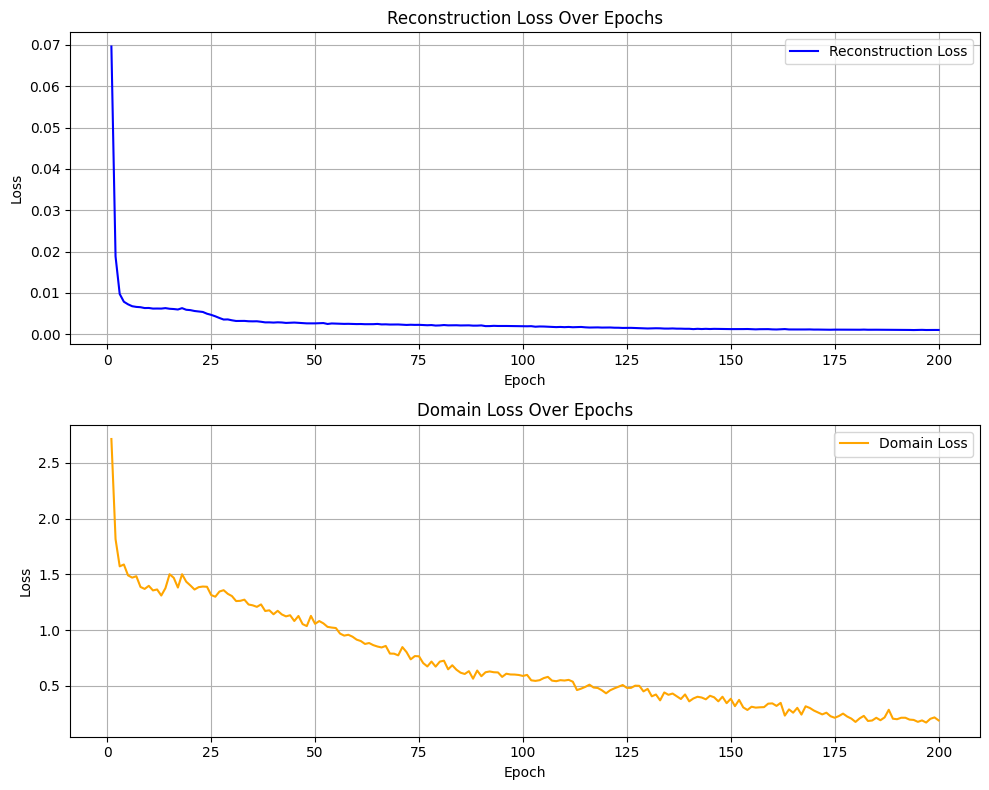

In [10]:
# After training, plot the losses
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Reconstruction Loss
axs[0].plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss', color='blue')
axs[0].set_title('Reconstruction Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()
axs[0].legend()

# Plot Domain Loss
axs[1].plot(range(1, num_epochs + 1), domain_losses, label='Domain Loss', color='orange')
axs[1].set_title('Domain Loss Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()

15/15 [==============================] - 0s 2ms/step
(450, 64)


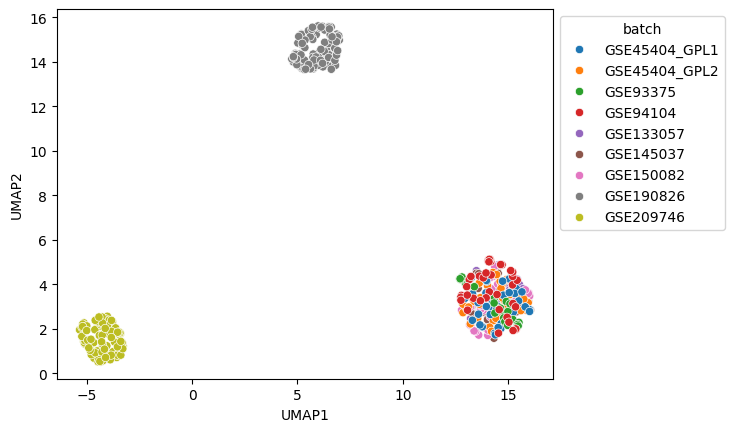

In [11]:
#grab the represetations from the trained model
low_dimensional_representation = encoder.predict(gene_expression_data)

#verify the shape
print(low_dimensional_representation.shape)

#set up the umap

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(low_dimensional_representation)

#checking batch separation
categories =  adata.obs['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':categories}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

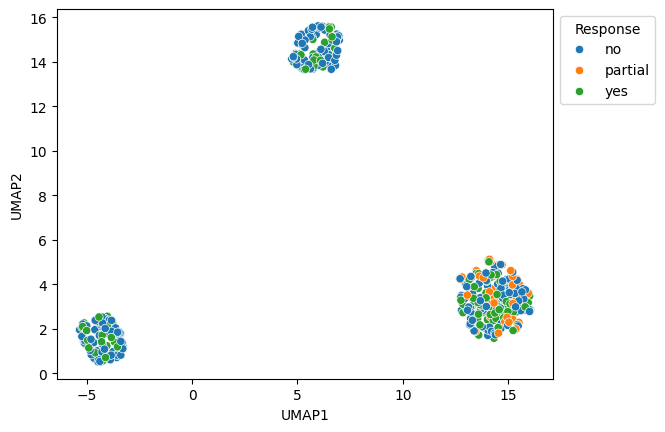

In [12]:
#checking response variable separation
categories =  adata.obs['Response']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'Response':categories}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Response')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [20]:
!top

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


=top - 08:28:24 up 5 days, 20:34,  0 users,  load average: 21.22, 21.39, 12.59
Tasks:  21 total,   1 running,  12 sleeping,   0 stopped,   8 zombie
%Cpu(s): 36.6 us,  1.5 sy,  0.0 ni, 60.7 id,  0.0 wa,  0.9 hi,  0.4 si,  0.0 st
MiB Mem : 257534.7 total, 190671.8 free,  26457.6 used,  40405.2 buff/cache
MiB Swap:  73728.0 total,  73728.0 free,      0.0 used. 228807.8 avail Mem 

    PID USER      PR  NI    VIRT    RES    SHR S  %CPU  %MEM     TIME+ COMMAND  
 546609 root      20   0   20.4g   1.4g 375808 S  2260   0.6 179:48.39 python   
      1 root      20   0  909164 219220  19968 S  13.3   0.1   7:12.11 jupyter+ 
 545176 root      20   0   24.4g   1.5g 391680 S   6.7   0.6  93:15.98 python   
 546903 root      20   0    8888   3584   3072 R   6.7   0.0   0:00.01 top      
    111 root      20   0  673028  58368  15872 S   0.0   0.0   0:09.83 python   
    250 root      20   0       0      0      0 Z   0.0   0.0   0:00.00 git      
    267 root      20   0       0      0      0 Z   